In [1]:
using PyPlot
using DSP
using QuadGK

include("../src/num.jl")
include("../src/phy.jl")
using .num
using .physics

In [2]:
const t = 0.5
U = 0.3
T = 10.
const nωn = 2^12
const nω = 2^12
const Nd = 20
ωrange = [-4.0,4.0]
const zeroplus = 0.01
const itermax = 200
const tol = 0.01
const mix = 0.50;
kB = 8.617333262145e-5;

In [3]:
ω = range(ωrange[1],length=nω,stop=ωrange[2])
ω = convert(Array{Float64},ω);

β = 1. / kB / T

ωn = π .* (2 .* collect(1:nωn) .+ 1) ./ β;

In [4]:
@time D0ω = baredos.("bethe",t,ω);

  0.465969 seconds (1.72 M allocations: 89.328 MiB, 5.32% gc time)


In [5]:
function OF_solver(ω,bare_dos,Nd,Nωn,Nω,U,T,zeroplus,tol,mix,itermax)
Σ1 = U .* [0.0 -0.0]
    
ρr = D0ω[1:4:nω]
wr  = ω[1:4:nω]

g_loc = zeros(ComplexF64,nω,2)
g_iωn = zeros(ComplexF64,nωn,2)
Σcalc = zeros(ComplexF64,nω,2)
Σcalc_r = zeros(ComplexF64,nω,2) .* Σ1
    
for iω in 1:nω
    ζ_up = ω[iω] + im * zeroplus
    ζ_down = ω[iω] + im * zeroplus
        
    intg = ρr ./ (ζ_up*ζ_down .- wr.^2.)
    sum = trapz(wr,intg)   
        
    g_loc[iω,1] = sum * ζ_down
    g_loc[iω,2] = sum * ζ_up
end

for iω in 1:nωn
    ζ_up = im .* ωn[iω]
    ζ_down = im .* ωn[iω]
        
    intg = ρr ./ (ζ_up*ζ_down .- wr.^2.)
    sum = trapz(wr,intg)   
        
    g_iωn[iω,1] = sum * ζ_down
    g_iωn[iω,2] = sum * ζ_up
end

ncalc = Σ1 ./ U

nf = fermi.(ω,T)
        
df,wd = zeros(Float64,2,Nd),zeros(Float64,Nd)

Σloc_iωn = zeros(Float64,2)
Σcalc_iωn = ones(ComplexF64,nωn,2) .* Σ1
Glocs = zeros(ComplexF64,nωn,2,Nd,Nd)
Seff = zeros(ComplexF64,Nd,Nd)
P = zeros(Float64,Nd,Nd)
Z = 0.0
Gave = zeros(ComplexF64,nωn,2)

Σloc = zeros(Float64,2)
Σcalc_r = ones(ComplexF64,nω,2) .* Σ1
Glocs_r = zeros(ComplexF64,nω,2,Nd,Nd)
        
dx,wd = QuadGK.gauss(Nd)
wdx = wd * transpose(wd)
for i = 1:2
    df[i,:] = sign(vec([1.0 -1.0])[i] ./ U) .* dx
end

for m_iter in 1:itermax
    #global Σloc_iωn
            
    giωn_old = deepcopy(g_iωn)
    Σcalciωn_old = deepcopy(Σcalc_iωn)

    Σωn_fluc = Σcalc_iωn
    
    gmf_iωn = 1. ./ ( (1. ./ g_iωn) .+ Σωn_fluc)
    
    @fastmath @inbounds for (iNd1,dfn1) in enumerate(df[1,:])
        @fastmath @inbounds for (iNd2,dfn2) in enumerate(df[2,:])

        Σloc_iωn[1] = 0.5 * U .* (ncalc[1].+ dfn1)
        Σloc_iωn[2] = 0.5 * U .* (ncalc[2].+ dfn2)
        Σloc_iωn = reshape(Σloc_iωn,1,2)

        Glocsinv = (1. ./ gmf_iωn) .- Σloc_iωn .- Σωn_fluc

        determ = gmf_iωn .* Glocsinv
        determ = determ[:,1] .* determ[:,2]

        Seff[iNd1,iNd2] = -sum(log.(determ))

        Glocs[:,:,iNd1,iNd2] = 1. ./ Glocsinv

        end
    end
    
    P = exp.(-real.(Seff .- minimum(real.(Seff))))
    Z = sum(P .* wdx)
    
    Gave = zeros(ComplexF64,size(g_iωn))
    @fastmath @inbounds for i = 1:nωn
        @fastmath @inbounds for dim in 1:2 Gave[i,dim] = sum(P[:,:] .* Glocs[i,dim,:,:] .* wdx) end
    end
    Gave = Gave ./ Z
    
    Σcalc_iωn = 1. ./ gmf_iωn .- 1. ./ Gave
    
    Σcalc_iωn = 0. .+ im .* imag(Σcalc_iωn)

    @fastmath @inbounds for (iωn,ωnx) in enumerate(ωn)
        ζup = im*ωn[iωn] - Σcalc_iωn[iωn,1]
        ζdw = im*ωn[iωn] - Σcalc_iωn[iωn,2]
                
        intg = ρr ./ (ζup*ζdw .- wr.^2.)
        sum = trapz(wr,intg) 
                
        g_iωn[iωn,1] = sum * ζdw
        g_iωn[iωn,2] = sum * ζup
    end
    
    convg, error = convergent(giωn_old,g_iωn,ωn,nωn,tol)
    
    if convg==true
        break
    end
    
end

for r_iter = 1:20
    #global Σloc

    gloc_old = deepcopy(g_loc)

    Σ_fluc = Σcalc_r

    gmf = 1. ./ ( (1. ./ g_loc) .+ Σ_fluc )

    @fastmath @inbounds for (iNd1,dfn1) in enumerate(df[1,:])
        @fastmath @inbounds for (iNd2,dfn2) in enumerate(df[2,:])
            Σloc[1] = 0.5 * U .* (ncalc[1] .+ dfn1)
            Σloc[2] = 0.5 * U .* (ncalc[2] .+ dfn2)
            Σloc = reshape(Σloc,1,2)

            Glocs_r[:,:,iNd1,iNd2] = 1 ./ ( (1. ./ gmf) .- Σloc .- Σ_fluc)
        end
    end

    Gave = zeros(ComplexF64,size(g_loc))
    @fastmath @inbounds for i = 1:nω
        @fastmath @inbounds for dim in 1:2 Gave[i,dim] = sum(P .* Glocs_r[i,dim,:,:] .* wdx) end
    end
    Gave = Gave ./ Z;

    Σcalc_r = 1 ./ gmf .- 1 ./ Gave;
    Σcalc_r = Σcalc_r .* 0.2
        
    hsi = zeros(Float64,size(Σcalc_r))    
    for i in 1:2 hsi[:,i] = imag.(Util.hilbert(imag(Σcalc_r[:,i]))) end
        
    Σcalc_r = hsi .+ im .* imag(Σcalc_r)
        

    @fastmath @inbounds for i = 1:nω
        ζup = ω[i] + im * zeroplus - Σcalc_r[i,1]
        ζdw = ω[i] + im * zeroplus - Σcalc_r[i,2]
    
        intg = ρr ./ (ζup*ζdw .- wr.^2)
        sum = trapz(wr,intg)
    
        g_loc[i,1] = sum * ζdw
        g_loc[i,2] = sum * ζup
    end

    ncalc = zeros(Float64,2)
    @fastmath @inbounds for i in 1:2
        ncalc[i] = -1/π .* trapz(ω,imag(g_loc[:,i]) .* nf)
    end
    
    ncalc .= 0.0
    
    #Σcalc_r[:,1] = U * (ncalc[1] - sum(ncalc)) .* ones(Float64,nω)
    #Σcalc_r[:,2] = U * (ncalc[2] - sum(ncalc)) .* ones(Float64,nω)
    
    #magnet = (ncalc[2] - ncalc[1]) / sum(ncalc)

    convg, error = convergent(gloc_old,g_loc,ω,nω,tol)
    
    if convg==true
        break
    end

end
    
    return g_iωn, Σcalc_iωn, P, g_loc, Σcalc_r

end

OF_solver (generic function with 1 method)

In [6]:
Us = [1.0, 2.0, 3.0]
nU = length(Us)

g1 = zeros(ComplexF64,nω,2,nU)
g2 = zeros(ComplexF64,nωn,2,nU)
PU = zeros(Float64,Nd,Nd,nU)
Σ1 = zeros(ComplexF64,nω,2,nU)
Σ2 = zeros(ComplexF64,nωn,2,nU)

for (iU,U) in enumerate(Us)
    g2[:,:,iU], Σ2[:,:,iU], PU[:,:,iU], g1[:,:,iU], Σ1[:,:,iU] = OF_solver(ω,D0ω,Nd,nωn,nω,U,T,zeroplus,tol,mix,itermax);
end

In [7]:
using DelimitedFiles
string = ["1.dat", "2.dat", "3.dat"]
for iU in 1:nU
    open("giwn"*string[iU],"w") do io
        writedlm(io,[ωn real(sum(g2[:,:,iU],dims=2)) imag(sum(g2[:,:,iU],dims=2))])
    end
    open("siwn"*string[iU],"w") do io
        writedlm(io,[ωn real(sum(Σ2[:,:,iU],dims=2)) imag(sum(Σ2[:,:,iU],dims=2))])
    end
end

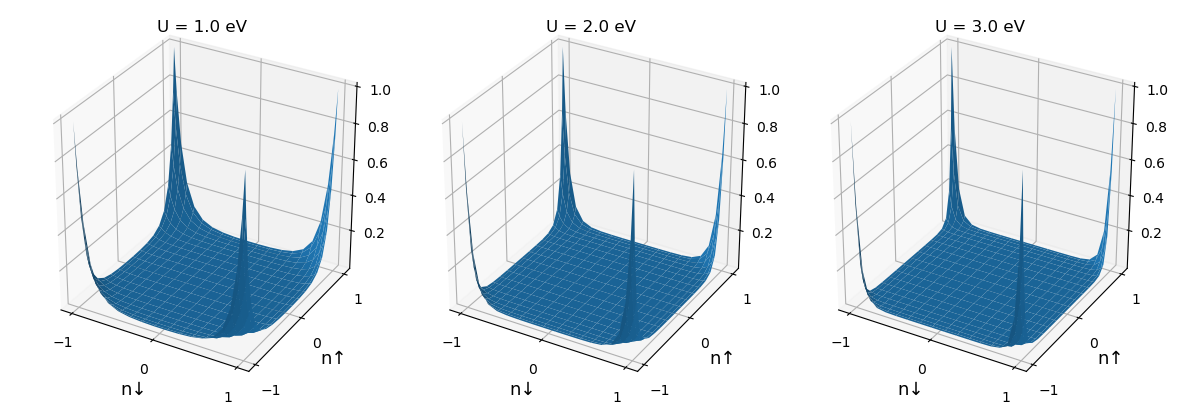

In [11]:
dx,wd = QuadGK.gauss(Nd)

fig = plt.figure(figsize=(15,5))

ax =  fig.add_subplot(1, 3, 1, projection="3d")
ax = fig.subplots_adjust(wspace=0.01)
surf(dx,dx,PU[:,:,1])
plt.locator_params(axis="x", nbins=2)
plt.locator_params(axis="y", nbins=2)
plt.xlabel("n↓",fontsize=13)
plt.ylabel("n↑",fontsize=13)
plt.title("U = 1.0 eV")

ax = fig.add_subplot(1, 3, 2, projection="3d")
surf(dx,dx,PU[:,:,2])
plt.locator_params(axis="x", nbins=2)
plt.locator_params(axis="y", nbins=2)
plt.xlabel("n↓",fontsize=13)
plt.ylabel("n↑",fontsize=13)
plt.title("U = 2.0 eV")

ax = fig.add_subplot(1, 3, 3, projection="3d")
surf(dx,dx,PU[:,:,3])
plt.locator_params(axis="x", nbins=2)
plt.locator_params(axis="y", nbins=2)
plt.xlabel("n↓",fontsize=13)
plt.ylabel("n↑",fontsize=13)
plt.title("U = 3.0 eV")

plt.show()
plt.savefig("OF_probs_paramagnetic.pdf",format="pdf")

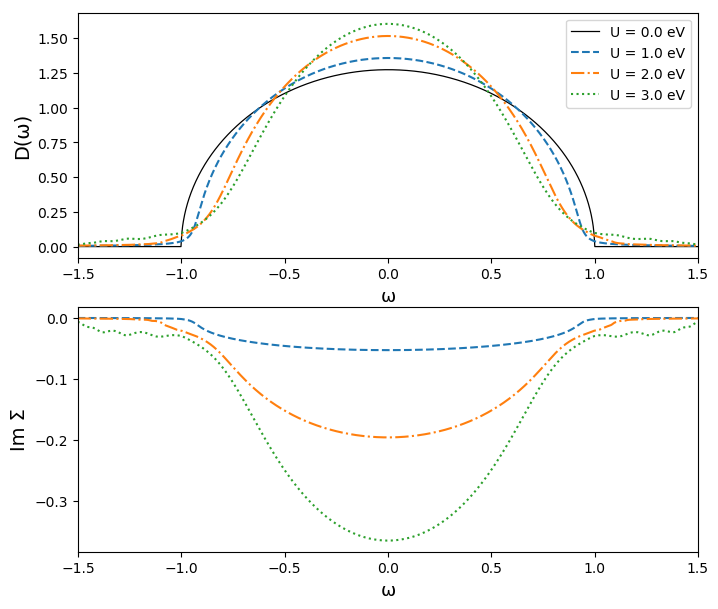

In [12]:
dashtype = ["--","-.",":"]

plt.figure(figsize=(8,7))
plt.subplot(2,1,1)
plt.plot(ω,D0ω*2,color="black",linewidth=0.9,label="U = 0.0 eV")
for iU in 1:nU
    plt.plot(ω,
        -imag(sum(g1[:,:,iU],dims=2))/π .* 2 ./ trapz(ω,-imag(sum(g1[:,:,iU],dims=2))/π),
        dashtype[iU],label="U = $(Us[iU]) eV")
end
plt.xlim(-1.5,1.5)
plt.xlabel("ω",fontsize=13)
plt.ylabel("D(ω)",fontsize=14)
plt.legend()

plt.subplot(2,1,2)
for iU in 1:nU
    plt.plot(ω,imag(sum(Σ1[:,:,iU],dims=2))/π,dashtype[iU])
end
plt.xlim(-1.5,1.5)
plt.xlabel("ω",fontsize=13)
plt.ylabel("Im Σ",fontsize=14)

plt.show()
plt.savefig("OF_dos_paramagnetic.pdf",format="pdf")